### Import Libraries and Load Data

In [198]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import pickle

### Load Data

In [199]:
destinations = pd.read_csv('../data/Expanded_Destinations.csv')
reviews = pd.read_csv('../data/Final_Updated_Expanded_Reviews.csv')
userHistory = pd.read_csv('../data/Final_Updated_Expanded_UserHistory.csv')
users = pd.read_csv('../data/Final_Updated_Expanded_Users.csv')

In [200]:
destinations.head()

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun


In [201]:
reviews.head()

,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!


In [202]:
userHistory.head()

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4


In [203]:
users.head()

,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2


### Data Preprocessing

In [204]:
reviews_destination = pd.merge(reviews,destinations,on='DestinationID', how='inner')
reviews_destination_userhistory = pd.merge(reviews_destination,userHistory,on='UserID', how='inner')
df = pd.merge(reviews_destination_userhistory,users,on='UserID', how='inner')
df.head()

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0


In [205]:
df.shape

(993, 20)

In [206]:
df.duplicated().sum()

np.int64(0)

In [207]:
df.isnull().sum()

ReviewID            0
DestinationID_x     0
UserID              0
Rating              0
ReviewText          0
Name_x              0
State               0
Type                0
Popularity          0
BestTimeToVisit     0
HistoryID           0
DestinationID_y     0
VisitDate           0
ExperienceRating    0
Name_y              0
Email               0
Preferences         0
Gender              0
NumberOfAdults      0
NumberOfChildren    0
dtype: int64

### Data Visualization

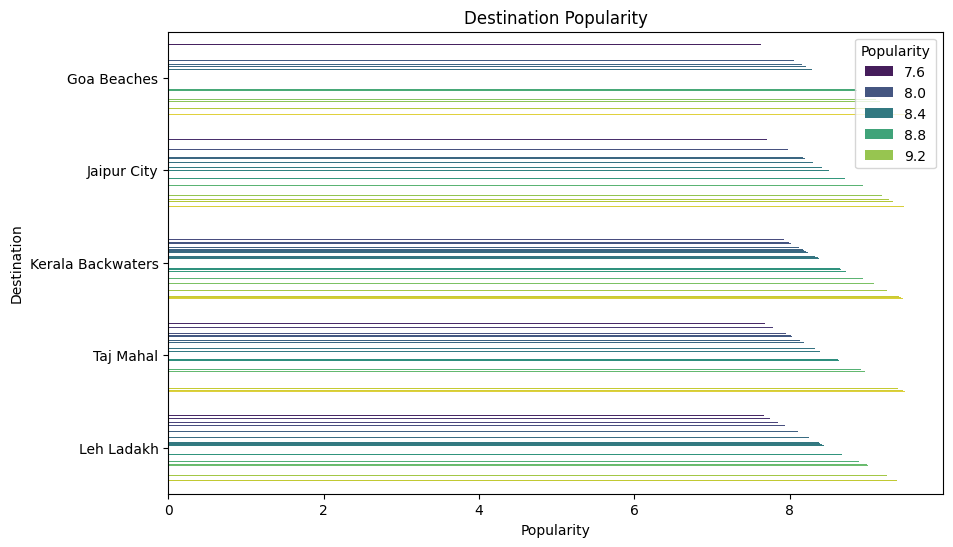

In [208]:
# Destination popularity
plt.figure(figsize=(10,6))
sns.barplot(x='Popularity', y='Name', data = destinations.sort_values
           (by='Popularity',ascending=False), hue='Popularity', palette='viridis')
plt.title('Destination Popularity')
plt.xlabel('Popularity')
plt.ylabel('Destination')
plt.show()

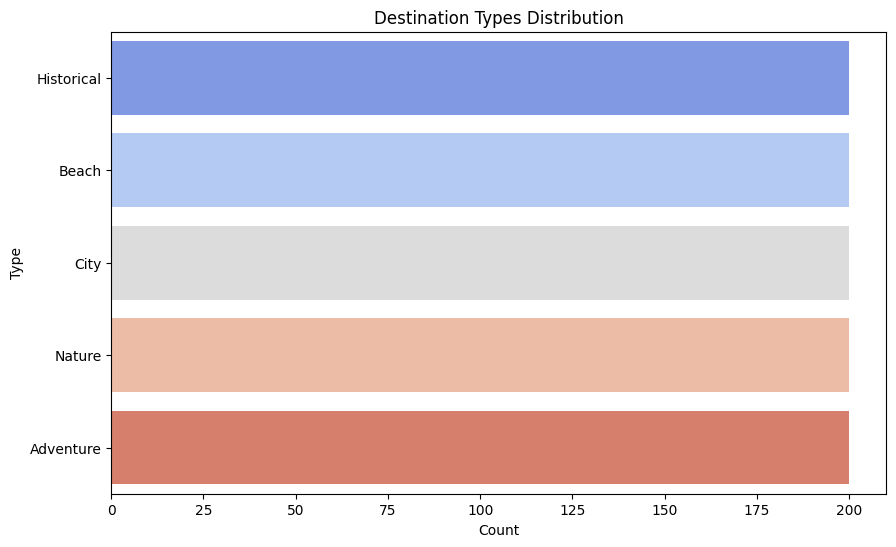

In [209]:
# Destination Types Distribution
plt.figure(figsize=(10,6))
sns.countplot(y='Type', data=destinations,hue='Type', palette='coolwarm')
plt.title('Destination Types Distribution')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

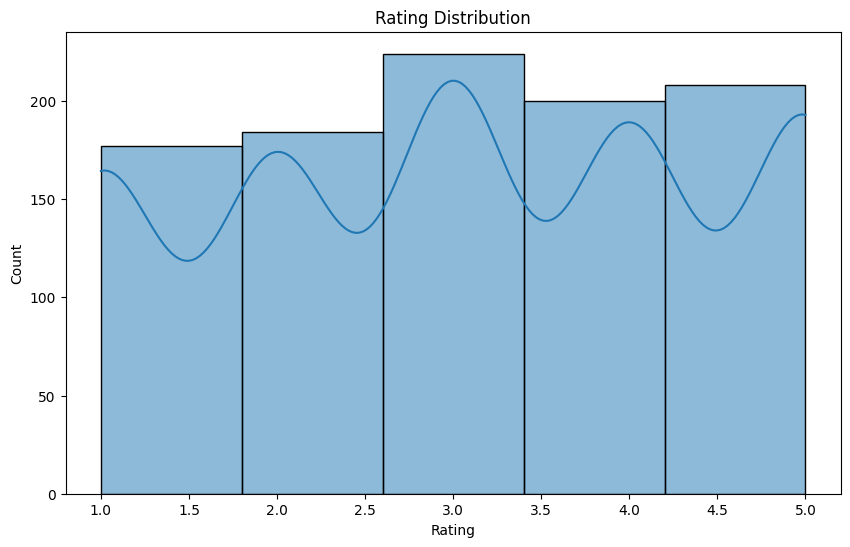

In [210]:
# Rating Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Rating'], bins=5, kde=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Content-Based Recommendation Model

#### Prepare the Destination Features


In [211]:
df['features'] = (
    df['Type'].astype(str) + " " +
    df['State'].astype(str) + " " +
    df['BestTimeToVisit'].astype(str) + " " +
    df['Preferences'].astype(str)
)

In [212]:
df.head()
df.to_csv('../data/final_df.csv', index=False)

In [213]:
vectorizer = TfidfVectorizer(stop_words='english')
destination_features = vectorizer.fit_transform(df['features'])

destination_features.toarray()

array([[0.        , 0.        , 0.        , ..., 0.47425946, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.4433145 ],
       [0.34511087, 0.        , 0.        , ..., 0.51672584, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.43591168],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.43591168],
       [0.        , 0.        , 0.        , ..., 0.47425946, 0.        ,
        0.        ]], shape=(993, 20))

In [214]:
cos_sim = cosine_similarity(destination_features,destination_features)

In [215]:
cos_sim

array([[1.        , 0.30209204, 0.80314548, ..., 0.10628488, 0.10628488,
        1.        ],
       [0.30209204, 1.        , 0.10568682, ..., 0.89329488, 0.89329488,
        0.30209204],
       [0.80314548, 0.10568682, 1.        , ..., 0.        , 0.        ,
        0.80314548],
       ...,
       [0.10628488, 0.89329488, 0.        , ..., 1.        , 1.        ,
        0.10628488],
       [0.10628488, 0.89329488, 0.        , ..., 1.        , 1.        ,
        0.10628488],
       [1.        , 0.30209204, 0.80314548, ..., 0.10628488, 0.10628488,
        1.        ]], shape=(993, 993))

#### Recommendation Function

In [216]:
def recommend_destinations(user_id,userHistory, destinations,cos_sim):
  visited_destinations = userHistory[userHistory['UserID'] == user_id]['DestinationID'].values
  # calculate similarity scores for visited destinations
  similar_scores = np.sum(cos_sim[visited_destinations-1],axis=0)
  recommended_destinations = np.argsort(similar_scores)[::-1]
  # Recommend top five destination where user hasn't visited
  recommend = []
  for idx in recommended_destinations:
    if destinations.iloc[idx]['DestinationID'] not in visited_destinations:
      recommend.append(destinations.iloc[idx][['DestinationID','Name','State','Type','BestTimeToVisit']].to_dict())
      if len(recommend) == 5:
        break
  return pd.DataFrame(recommend)


recommend_destinations = recommend_destinations(1,userHistory,destinations,cos_sim)

In [217]:
recommend_destinations.head()

,DestinationID,Name,State,Type,BestTimeToVisit
0,64,Kerala Backwaters,Kerala,Nature,Sep-Mar
1,62,Goa Beaches,Goa,Beach,Nov-Mar
2,63,Jaipur City,Rajasthan,City,Oct-Mar
3,41,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb
4,42,Goa Beaches,Goa,Beach,Nov-Mar


### Collaborative Filtering

#### Create a User-Item Matrix

In [218]:
user_item_matrix = userHistory.pivot(index='UserID', columns='DestinationID', values='ExperienceRating')
user_item_matrix.fillna(0,inplace=True)
user_item_matrix.head()

DestinationID,2,3,4,5,6,7,8,9,10,11,...,987,988,990,991,993,994,996,997,998,1000
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cosine Similarity Between Users

In [219]:
user_sim = cosine_similarity(user_item_matrix,user_item_matrix)

In [220]:
user_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(642, 642))

In [221]:
def collaborative_recommend(userID, user_sim, user_item_matrix, destinations):
  #Find similar users
  similar_users = user_sim[userID - 1]
  #Get five similar users
  similar_users_idx = np.argsort(similar_users)[::-1][1:6]
  #Get the destinations that the similar users liked
  similar_users_ratings = user_item_matrix.iloc[similar_users_idx].mean(axis=0)
  recommended_destinations = similar_users_ratings.sort_values(ascending=False).head(5).index
  # recommend top 5 items
  recommendations = destinations[destinations['DestinationID'].isin(recommended_destinations)][[
      'DestinationID','Name','Type','State','BestTimeToVisit']]
  return recommendations

In [222]:
collaborative_recommendation = collaborative_recommend(11,user_sim,user_item_matrix,destinations)

collaborative_recommendation.head()

,DestinationID,Name,Type,State,BestTimeToVisit
300,301,Taj Mahal,Historical,Uttar Pradesh,Nov-Feb
345,346,Taj Mahal,Historical,Uttar Pradesh,Nov-Feb
367,368,Jaipur City,City,Rajasthan,Oct-Mar
724,725,Leh Ladakh,Adventure,Jammu and Kashmir,Apr-Jun
969,970,Leh Ladakh,Adventure,Jammu and Kashmir,Apr-Jun


### User input feature based Recommendation

In [223]:
data = df.copy()
data

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,...,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren,features
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,...,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1,"City Rajasthan Oct-Mar City, Historical"
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,...,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1,"Historical Uttar Pradesh Nov-Feb City, Historical"
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,...,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1,"City Rajasthan Oct-Mar Nature, Adventure"
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,...,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0,"Nature Kerala Sep-Mar Nature, Adventure"
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,...,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0,"City Rajasthan Oct-Mar City, Historical"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,...,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,...,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,...,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,...,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."


In [224]:
features = ['Name_x','State','Type','BestTimeToVisit','Preferences',
            'Gender','NumberOfChildren']

In [225]:
data[features]

,Name_x,State,Type,BestTimeToVisit,Preferences,Gender,NumberOfChildren
0,Jaipur City,Rajasthan,City,Oct-Mar,"City, Historical",Female,1
1,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"City, Historical",Male,1
2,Jaipur City,Rajasthan,City,Oct-Mar,"Nature, Adventure",Male,1
3,Kerala Backwaters,Kerala,Nature,Sep-Mar,"Nature, Adventure",Female,0
4,Jaipur City,Rajasthan,City,Oct-Mar,"City, Historical",Male,0
...,...,...,...,...,...,...,...
988,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,0
989,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,0
990,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,2
991,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,2


In [226]:
#Encoding
label_encoders = {}

for col in features:
  if data[col].dtype == 'object':
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data[features]

,Name_x,State,Type,BestTimeToVisit,Preferences,Gender,NumberOfChildren
0,1,3,2,3,1,0,1
1,4,4,3,1,1,1,1
2,1,3,2,3,2,1,1
3,2,2,4,4,2,0,0
4,1,3,2,3,1,1,0
...,...,...,...,...,...,...,...
988,4,4,3,1,0,1,0
989,4,4,3,1,0,1,0
990,4,4,3,1,0,1,2
991,4,4,3,1,0,1,2


In [227]:
X = data[features]
y = data['Popularity']

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


#### Model Training

In [229]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train,y_train)
# Evaluate Model
y_pred = model.predict(X_test)

print("MSE: ",mean_squared_error(y_test,y_pred))
print("MAE: ",mean_absolute_error(y_test,y_pred))
print("R2: ",r2_score(y_test,y_pred))

MSE:  0.35623104830808155
MAE:  0.5141496675289093
R2:  -0.09253725565503812


#### Example User Input

In [230]:
def recommend_destinations_user_input(user_input, model, label_encoders, features):
  #Encode user input
  encoded_input = {}
  for feature in features:
    if feature in label_encoders:
      encoded_input[feature] = label_encoders[feature].transform([user_input[feature]])[0]
    else:
      encoded_input[feature] = user_input[feature]

  input = pd.DataFrame([encoded_input])

  predicted_popularity = model.predict(input)[0]

  return predicted_popularity

user_input = {
    'Name_x': 'Jaipur City',
    'Type': 'City',
    'State': 'Rajasthan',
    'BestTimeToVisit': 'Oct-Mar',  # This might be an unseen label
    'Preferences': 'City, Historical',
    'Gender': 'Female',
    'NumberOfAdults': 2,
    'NumberOfChildren': 1,
}

predicted_popularity = recommend_destinations_user_input(user_input, model, label_encoders, features)

print(f"Predicted Popularity Score: {predicted_popularity:.2f}")

Predicted Popularity Score: 8.13


In [231]:
pickle.dump(model,open("../models/model.pkl",'wb'))
pickle.dump(label_encoders,open("../models/label_encoders.pkl",'wb'))